# 1. Import data and python packages

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
sns.set_style("dark")
sns.set(style="darkgrid", color_codes=True)

import matplotlib.pyplot as plt

# Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation
from sklearn.metrics import accuracy_score

# Cross Validation
from sklearn.model_selection import cross_val_score

# Possible Models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

# Hyperparameter Tuning/Optimization
import optuna

# Deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.backend import clear_session

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [2]:
# Import the training data
training_path = "train.csv"
training_df = pd.read_csv(training_path)

# Import the test data
testing_path =  "test.csv"
test_df = pd.read_csv(testing_path)

# 2. Missing Values

In [3]:
# Peek at the data
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(training_df.shape)
training_df.isna().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We need to handle the Age, Cabin and Embarked

## 2.1. Age

In [5]:
## How much is missing
count_rows = training_df.shape[0]
count_missing_age = sum(training_df["Age"].isna())

print(f"Percentage of rows with missing age is {round(count_missing_age/count_rows*100,2)}%")

Percentage of rows with missing age is 19.87%


In [6]:
# How we'll replace the Age
age_mean = training_df["Age"].mean()
age_median = training_df["Age"].median()

age_imputer = 29 # between the median (28) and mean (~30)

print(f"The mean age is {age_mean} and the median age is {age_median}, the imput will be 29")

# For the age we'll handle the N/As by imputing 29 (age_imputer)

The mean age is 29.69911764705882 and the median age is 28.0, the imput will be 29


## 2.2. Embarked

In [7]:
training_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
missing_embarked = sum(training_df["Embarked"].isna())

print(f"We have {missing_embarked} rows with missing values on the Embarked column. We'll imput 'S' since that's the most common value")

We have 2 rows with missing values on the Embarked column. We'll imput 'S' since that's the most common value


## 2.3. Cabin

In [9]:
missing_cabin = training_df['Cabin'].isna().sum()
print(f"Percentage of rows missing Cabin is {round(missing_cabin/count_rows * 100,2)}")

Percentage of rows missing Cabin is 77.1


There are too many cell missing the Cabin for us to input.
The missing rows should be because the data was just not collected (my understanding is all passengers and crew had a cabin).

The best way to handle this will be to drop the column altogether.

In [10]:
# ********************* Cleanup actions *********************

train_data = training_df.copy()
train_data["Age"].fillna(28, inplace=True)
train_data["Embarked"].fillna("S", inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [11]:
# Chekcing the train data has no missing values or "NA values"
train_data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# 3. Data Exploration

## 3.1. Age Exploration

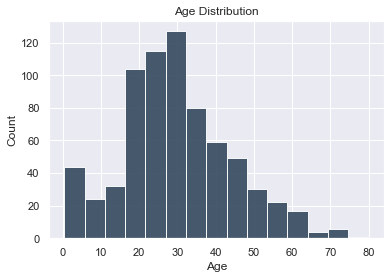

In [12]:
# We'll use the traning_df to avoid the imputation on age
ax = training_df["Age"].hist(bins=15, color='#34495e', alpha=0.9)
ax.set(xlabel='Age', ylabel='Count')
plt.title('Age Distribution')
plt.show()

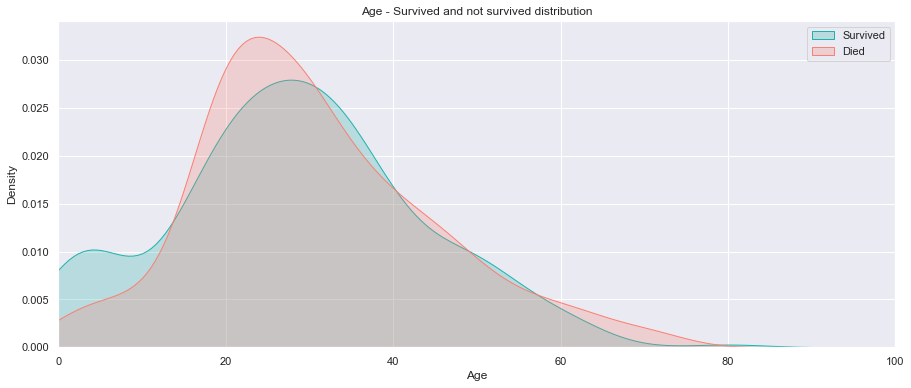

In [19]:
plt.figure(figsize=(15,6))
sns.kdeplot(training_df["Age"][training_df["Survived"] == 1], color="lightseagreen", shade=True)
sns.kdeplot(training_df["Age"][training_df["Survived"] == 0], color="salmon", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Age - Survived and not survived distribution')
# Display the Grath stating at 0
plt.xlim(0, 100)

# Highlight the part 0-15
#plt.axvspan(0, 15, color='palegreen', alpha=0.5)

# Highlight the part 55 - 80
#plt.axvspan(60, 80, color='lightcoral', alpha=0.5)

plt.show()


In [14]:
age_data = training_df[["Age", "Survived"]]
age_data_clean = age_data.dropna()
age_data_clean['Age'] = age_data_clean['Age'].astype('int')

age_mean_df = age_data_clean.groupby('Age', as_index=False).mean()

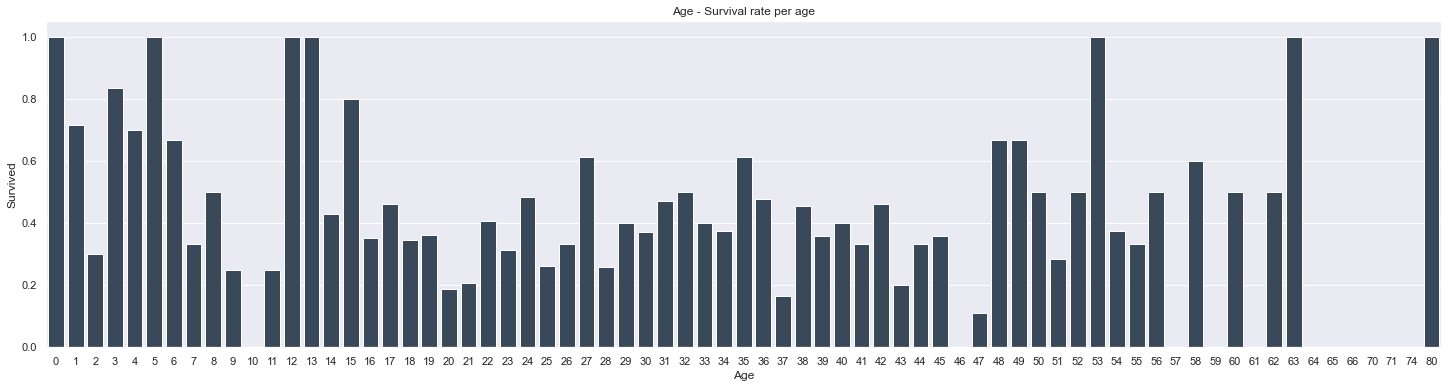

In [15]:
plt.figure(figsize=(25,6))
sns.barplot(x='Age', y='Survived', data=age_mean_df, color="#34495e")
plt.title('Age - Survival rate per age')
plt.show()


### <b>Age Exploration Conclusion</b>

From the data visualizations we can see that there was an effort made to save children. </br>
We see the survival rate on 0-15 is significantly higher than the rest. </br>
On the other side we see that as the age is over 60 we see lower survivability rates </br>

<b>Conclusion</b> </br>
New categorical var: Under 16 </br>
New categorical var: Over 60

## 3.2. Sex Exploration

In [18]:
sex_mean_df = train_data[["Sex", "Survived"]].groupby("Sex", as_index=False).mean()
sex_mean_df

,Sex,Survived
0,female,0.742038
1,male,0.188908


### <b>Sex Exploration Conclusion</b>

Women are far more likelly to have survived than men

Categorical var: is_men

## 3.3 Passanger class Exploration

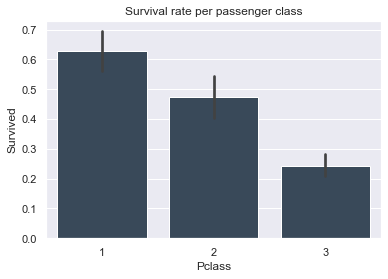

In [17]:
sns.barplot(data=train_data, x="Pclass", y="Survived", color="#34495e")
plt.title("Survival rate per passenger class")
plt.show()

## 3.4 Fare Exploration

Text(0.5, 1.0, 'Survival rate to fare')

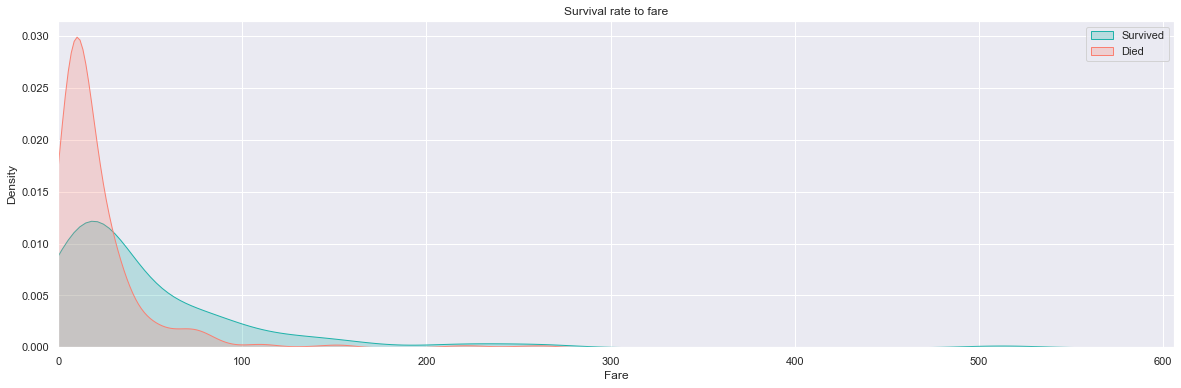

In [18]:
plt.figure(figsize=(20,6))
sns.kdeplot(data=train_data["Fare"][train_data["Survived"] == 1], color="lightseagreen", shade=True)
sns.kdeplot(data=train_data["Fare"][train_data["Survived"] == 0], color="salmon", shade=True)
plt.legend(['Survived', 'Died'])

# Start at 0
plt.xlim(0)
plt.title("Survival rate to fare")

# 4 - Feature Engineering

## 4.1 Travel Alone and count & # family members

In [19]:
# Let's simplify the family situation
# SibSp - count of siblings and spouses
# Parch - count of parents and children
train_data['family_count'] = train_data['SibSp'] + train_data['Parch']

# If the family count = 0 then the person travels alone (1), otherwise not (0)
train_data['travel_alone'] = np.where(train_data['family_count'] == 0, 1, 0)

train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [20]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,family_count,travel_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0,1


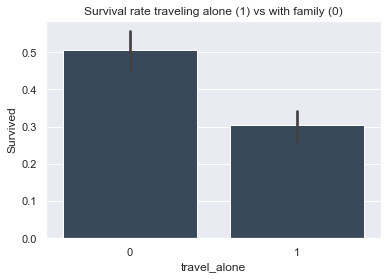

In [21]:
sns.barplot(data=train_data, x="travel_alone", y="Survived", color="#34495e")
plt.title("Survival rate traveling alone (1) vs with family (0)")
plt.show()


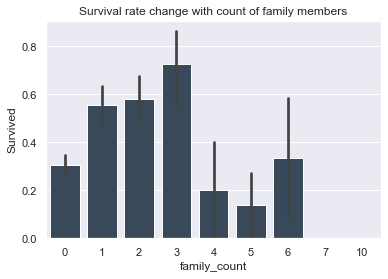

In [22]:
sns.barplot(data=train_data, x="family_count", y="Survived", color="#34495e")
plt.title("Survival rate change with count of family members")
plt.show()

## 4.2 Passanger Titles

In [23]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # Find a word between a space and with a .(dot) after
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
train_data['Title'] = train_data['Name'].apply(get_title)

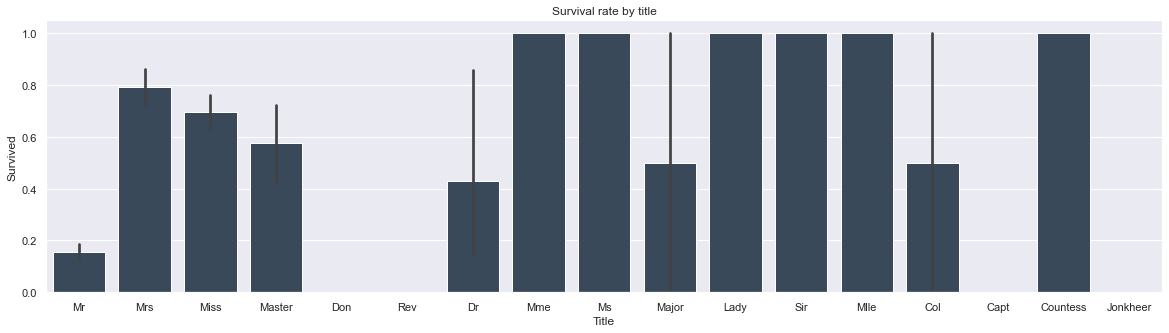

In [24]:
plt.figure(figsize=(20, 5))
sns.barplot(data=train_data, x="Title", y="Survived", color="#34495e")
plt.title("Survival rate by title")
plt.show()

In [25]:
#Categorize titles
train_data['Title'] = train_data['Title'].replace(['Lady', 'Countess', 'Dona'], 'Rare_F')
train_data['Title'] = train_data['Title'].replace(['Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer'], 'Rare_M')
train_data['Title'] = train_data['Title'].replace(['Dr', 'Rev'], 'Rare_U')

train_data['Title'] = train_data['Title'].replace('Mlle', 'Miss')
train_data['Title'] = train_data['Title'].replace('Ms', 'Miss')
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs')

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare_F": 5, "Rare_M": 6, "Rare_U": 7 }
train_data['Title'] = train_data['Title'].map(title_mapping)
train_data['Title'] = train_data['Title'].fillna(0)

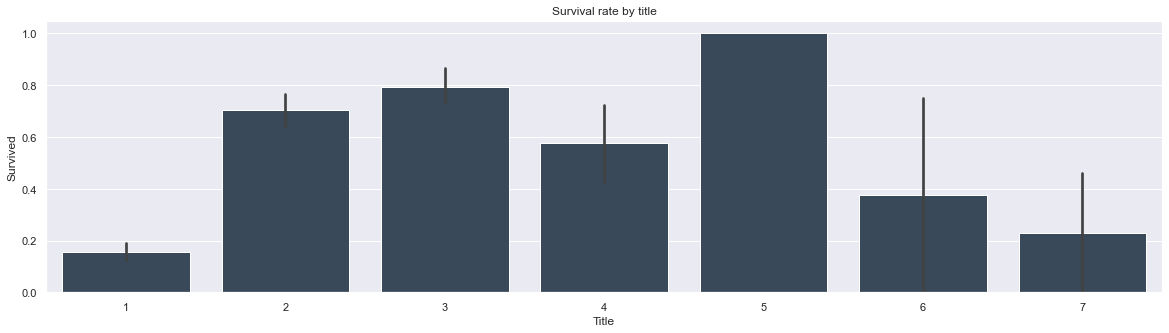

In [26]:
plt.figure(figsize=(20, 5))
sns.barplot(data=train_data, x="Title", y="Survived", color="#34495e")
plt.title("Survival rate by title")
plt.show()

In [27]:
# Note: Men with a rare title are about twice as likelly to survive

In [28]:
train_data.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [29]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,family_count,travel_alone,Title
0,1,0,3,male,22.0,7.2500,S,1,0,1
1,2,1,1,female,38.0,71.2833,C,1,0,3
2,3,1,3,female,26.0,7.9250,S,0,1,2
3,4,1,1,female,35.0,53.1000,S,1,0,3
4,5,0,3,male,35.0,8.0500,S,0,1,1


In [30]:
# Age Features
train_data["under_16"] = np.where(train_data['Age'] < 16, 1, 0)
train_data["over_60"] = np.where(train_data['Age'] > 60, 1, 0)

# One Hot Encodings
train_data = pd.get_dummies(train_data, prefix=['Sex'], columns=['Sex'], drop_first=True)
train_data = pd.get_dummies(train_data, prefix=['Embarked'], columns=['Embarked'], drop_first=True)

train_passengers = train_data['PassengerId']
train_data.drop('PassengerId', axis=1, inplace=True)
train_data.head()

,Survived,Pclass,Age,Fare,family_count,travel_alone,Title,under_16,over_60,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,7.2500,1,0,1,0,0,1,0,1
1,1,1,38.0,71.2833,1,0,3,0,0,0,0,0
2,1,3,26.0,7.9250,0,1,2,0,0,0,0,1
3,1,1,35.0,53.1000,1,0,3,0,0,0,0,1
4,0,3,35.0,8.0500,0,1,1,0,0,1,0,1


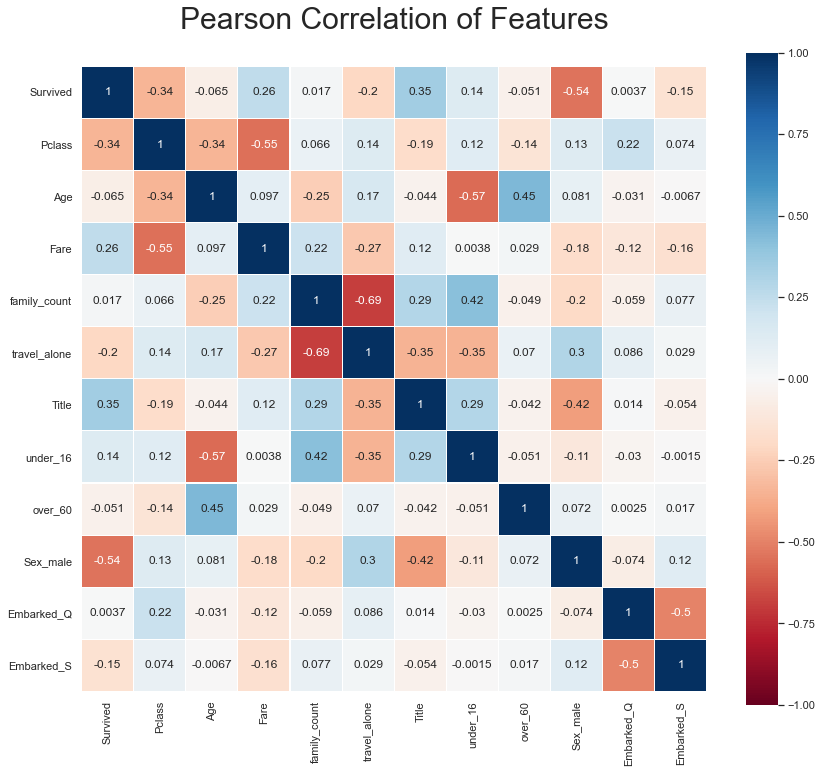

In [31]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', size=30, y=1.05)
sns.heatmap(train_data.astype(float).corr(),
linewidths=0.1,
vmax=1.0, 
vmin=-1,
square=True, 
cmap=colormap, 
linecolor='white', 
annot=True)
plt.show()

## 5. Model Selection

In [32]:
y = train_data['Survived'] #target variable
X = train_data.drop('Survived', axis=1)

In [33]:
# Train / Validation split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [34]:
# Starting Optuna Optimization
# Scikit-learn Models

def objective(trial):
    # Select classifier
    classifier_name = trial.suggest_categorical('classifier', ['MLPClassifier', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier'])

    if classifier_name == 'MLPClassifier':
        classifier_obj = MLPClassifier() # We'll manually tune if it looks promissing

    elif classifier_name == 'KNeighborsClassifier':
        sug_k = trial.suggest_int("k", 3, 8)
        classifier_obj = KNeighborsClassifier(n_neighbors=sug_k)
    
    elif classifier_name == 'SVC':
        sug_kernel = trial.suggest_categorical('kernel_svc', ['linear', 'poly', 'rbf', 'sigmoid'])
        sug_gamma = trial.suggest_categorical('svc_gamma', ['auto', 'scale'])
        classifier_obj = make_pipeline(StandardScaler(), SVC(gamma=sug_gamma, kernel=sug_kernel))
    
    elif classifier_name == 'DecisionTreeClassifier':
        sug_dtree_depth = trial.suggest_int("max_depth", 3, 8)
        classifier_obj = DecisionTreeClassifier(max_depth=sug_dtree_depth)
    
    elif classifier_name == 'RandomForestClassifier':
        sug_rtree_depth = trial.suggest_int("max_depth", 3, 8)
        sug_rtree_estims = trial.suggest_int("estimators", 30, 200)
        classifier_obj = RandomForestClassifier(max_depth=sug_rtree_depth, n_estimators=sug_rtree_estims)
    
    elif classifier_name == 'AdaBoostClassifier':
        sug_ada_estims = trial.suggest_int("estimators", 30, 600)
        classifier_obj = AdaBoostClassifier(n_estimators=sug_ada_estims)
    
    # Fit model
    classifier_obj.fit(train_X, train_y)

    # Run model on validation data
    preds = classifier_obj.predict(val_X)

    # Score model (cross validation)
    scores = cross_val_score(classifier_obj, X, y,
                              cv=5,
                              scoring='accuracy')

    score = sum(scores)/len(scores)


    return score

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=500)

In [36]:
print(study.best_trial)

FrozenTrial(number=441, values=[0.8395078777226791], datetime_start=datetime.datetime(2021, 7, 11, 21, 27, 30, 167326), datetime_complete=datetime.datetime(2021, 7, 11, 21, 27, 30, 576323), params={'classifier': 'RandomForestClassifier', 'max_depth': 8, 'estimators': 46}, distributions={'classifier': CategoricalDistribution(choices=('MLPClassifier', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier')), 'max_depth': IntUniformDistribution(high=8, low=3, step=1), 'estimators': IntUniformDistribution(high=200, low=30, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=441, state=TrialState.COMPLETE, value=None)


In [37]:
# optuna optimize xgb
def objective_xgb(trial):
    sug_gamma = trial.suggest_uniform('gamma', 0.0, 1.0)
    sug_subs = trial.suggest_uniform('subsamp', 0.0, 1.0)
    sug_cols = trial.suggest_uniform('colsamp', 0.0, 1.0)
    sug_maxd = trial.suggest_int('depth', 3, 15)

    xgb_class = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators= 2000,
    max_depth= sug_maxd,
    gamma=sug_gamma,                        
    subsample=sug_subs,
    colsample_bytree=sug_cols,
    objective= 'binary:logistic',
    early_stopping_rounds = 5,
    verbosity = 0
    )

    # Fit model
    xgb_class.fit(train_X, train_y)

    # Run model on validation data
    preds = xgb_class.predict(val_X)

    # Score model
    score = accuracy_score(val_y, preds)

    return score

new_study = optuna.create_study(direction="maximize")
new_study.optimize(objective_xgb, n_trials=200, timeout=300)

In [38]:
print(new_study.best_trial)

FrozenTrial(number=8, values=[0.820627802690583], datetime_start=datetime.datetime(2021, 7, 11, 21, 28, 12, 281667), datetime_complete=datetime.datetime(2021, 7, 11, 21, 28, 13, 552456), params={'gamma': 0.7274891849235545, 'subsamp': 0.24848227701074654, 'colsamp': 0.321793546686975, 'depth': 6}, distributions={'gamma': UniformDistribution(high=1.0, low=0.0), 'subsamp': UniformDistribution(high=1.0, low=0.0), 'colsamp': UniformDistribution(high=1.0, low=0.0), 'depth': IntUniformDistribution(high=15, low=3, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE, value=None)


In [39]:
# Keras test

def objective_keras(trial):
    clear_session()

    # Define the Keras Neural Network
    input_shape = [train_X.shape[1]]

    new_model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),
    ])

    n_layers = trial.suggest_int("n_layers", 1, 5)

    for i in range(n_layers):
        dropout = trial.suggest_float(f"dropout_l{i}", 0.05, 0.5)
        num_units= trial.suggest_int(f"n_units_l{i}", 16, 256, log=True)
        
        new_model.add(Dense(num_units, activation=trial.suggest_categorical(f"activation_fun{i}", ["relu", "linear", "sigmoid", "softplus", "softsign", "selu", "tanh"])))
        new_model.add(BatchNormalization())
        new_model.add(Dropout(dropout))
        
    new_model.add(Dense(1, activation='sigmoid'))

    new_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
        )
    
    early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    )

    new_model.fit(
        train_X, train_y,
        validation_data=(val_X, val_y),
        batch_size=trial.suggest_int(f"batch_size", 35, 200, log=True),
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )

    preds = new_model.predict(val_X)
    preds = [int(pred) for pred in preds]

    # Score model
    score = accuracy_score(val_y, preds)

    return score

In [40]:
study_ker = optuna.create_study(direction="maximize")
study_ker.optimize(objective_keras, n_trials=350, timeout=750)

In [41]:
print("Number of finished trials: {}".format(len(study_ker.trials)))

print("Best trial:")
trial = study_ker.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 344
Best trial:
  Value: 0.5739910313901345
  Params: 
    n_layers: 2
    dropout_l0: 0.26297511555128056
    n_units_l0: 35
    activation_fun0: sigmoid
    dropout_l1: 0.07420032619865535
    n_units_l1: 89
    activation_fun1: sigmoid
    batch_size: 75


In [42]:
# Best models

# scikit-learn
print(f"scikit-learn - score: {study.best_trial.values[0]} params: {study.best_trial.params}")

# XGBoost
print(f"XGBoost - score: {new_study.best_trial.values[0]} params: {new_study.best_trial.params}")

# Keras
print(f"Keras - score: {study_ker.best_trial.values[0]} layers: {study_ker.best_trial.params['n_layers']}")

scikit-learn - score: 0.8395078777226791 params: {'classifier': 'RandomForestClassifier', 'max_depth': 8, 'estimators': 46}
XGBoost - score: 0.820627802690583 params: {'gamma': 0.7274891849235545, 'subsamp': 0.24848227701074654, 'colsamp': 0.321793546686975, 'depth': 6}
Keras - score: 0.5739910313901345 layers: 2


## 6. Test & submission

### 6.1. Replicate data transformation on the Test data

In [43]:
# Test Data conversion

# ********************* Cleanup actions *********************
test_data = test_df.copy()
test_data["Age"].fillna(28, inplace=True)
test_data["Embarked"].fillna("S", inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# ***** Family Features
# Let's simplify the family situation
test_data['family_count'] = test_data['SibSp'] + test_data['Parch']

# If the family count = 0 then the person travels alone (1), otherwise not (0)
test_data['travel_alone'] = np.where(test_data['family_count'] == 0, 1, 0)

test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# ***** Title Feature
# Create a new feature Title, containing the titles of passenger names
test_data['Title'] = test_data['Name'].apply(get_title)

#Categorize titles
test_data['Title'] = test_data['Title'].replace(['Lady', 'Countess', 'Dona'], 'Rare_F')
test_data['Title'] = test_data['Title'].replace(['Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer'], 'Rare_M')
test_data['Title'] = test_data['Title'].replace(['Dr', 'Rev'], 'Rare_U')

test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss')
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss')
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs')

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare_F": 5, "Rare_M": 6, "Rare_U": 7 }
test_data['Title'] = test_data['Title'].map(title_mapping)
test_data['Title'] = test_data['Title'].fillna(0)

# ***** Age Features
test_data["under_16"] = np.where(test_data['Age'] < 16, 1, 0)
test_data["over_60"] = np.where(test_data['Age'] > 60, 1, 0)

# One Hot Encodings
test_data = pd.get_dummies(test_data, prefix=['Sex'], columns=['Sex'], drop_first=True)
test_data = pd.get_dummies(test_data, prefix=['Embarked'], columns=['Embarked'], drop_first=True)

# Drop Name and Ticket
test_data.drop(['Name', 'Ticket'], axis=1, inplace=True)

# Fill the missing Fare
test_data["Fare"].fillna(train_data['Fare'].mean(), inplace=True)

#remove the passsengerID column
test_passengers = test_data['PassengerId']
test_data.drop('PassengerId', axis=1, inplace=True)

test_data.head()

,Pclass,Age,Fare,family_count,travel_alone,Title,under_16,over_60,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,7.8292,0,1,1,0,0,1,1,0
1,3,47.0,7.0000,1,0,3,0,0,0,0,1
2,2,62.0,9.6875,0,1,1,0,1,1,1,0
3,3,27.0,8.6625,0,1,1,0,0,1,0,1
4,3,22.0,12.2875,2,0,3,0,0,0,0,1


In [44]:
train_data.drop('Survived', axis=1).head()

,Pclass,Age,Fare,family_count,travel_alone,Title,under_16,over_60,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,7.2500,1,0,1,0,0,1,0,1
1,1,38.0,71.2833,1,0,3,0,0,0,0,0
2,3,26.0,7.9250,0,1,2,0,0,0,0,1
3,1,35.0,53.1000,1,0,3,0,0,0,0,1
4,3,35.0,8.0500,0,1,1,0,0,1,0,1


### 6.2. Build the 3 models (best Scikit-learn, best XGBoost, best Keras)

In [45]:
# RFC
rfc = RandomForestClassifier(n_estimators=46, max_depth=8)
rfc.fit(X, y)

RandomForestClassifier(max_depth=8, n_estimators=46)

In [46]:
# XGBClassifier
xgb_class = xgb.XGBClassifier(
    learning_rate = 0.01,
    n_estimators= 2000,
    max_depth= 6,
    gamma=0.73,                        
    subsample=0.25,
    colsample_bytree=0.32,
    objective= 'binary:logistic',
    early_stopping_rounds = 5,
    verbosity = 0
    )
xgb_class.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.32,
              early_stopping_rounds=5, gamma=0.73, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [47]:
study_ker.best_trial.params

{'n_layers': 2,
 'dropout_l0': 0.26297511555128056,
 'n_units_l0': 35,
 'activation_fun0': 'sigmoid',
 'dropout_l1': 0.07420032619865535,
 'n_units_l1': 89,
 'activation_fun1': 'sigmoid',
 'batch_size': 75}

In [48]:
# Keras - Neural Net
clear_session()

# Define the Keras Neural Network
input_shape = [train_X.shape[1]]

new_model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
])

for i in range(study_ker.best_trial.params['n_layers']):
    new_model.add(Dense(study_ker.best_trial.params[f'n_units_l{i}'], activation=study_ker.best_trial.params[f'activation_fun{i}']))
    new_model.add(BatchNormalization())
    new_model.add(Dropout(study_ker.best_trial.params[f'dropout_l{i}']))

new_model.add(Dense(1, activation='sigmoid'))

new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
    
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

new_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=study_ker.best_trial.params['batch_size'],
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)

### 6.3 create submissions with the 3 models

In [49]:
test_data.head()

,Pclass,Age,Fare,family_count,travel_alone,Title,under_16,over_60,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,7.8292,0,1,1,0,0,1,1,0
1,3,47.0,7.0000,1,0,3,0,0,0,0,1
2,2,62.0,9.6875,0,1,1,0,1,1,1,0
3,3,27.0,8.6625,0,1,1,0,0,1,0,1
4,3,22.0,12.2875,2,0,3,0,0,0,0,1


In [50]:
# Predictions = RFC
svc_preds = rfc.predict(test_data)

# Create submission csv - RFC
output_rfc = pd.DataFrame({'PassengerId': test_passengers,
                       'Survived': svc_preds})
output_rfc.set_index('PassengerId')
output_rfc.to_csv('submission_rfc_r2.csv', index=False)


# Predictions = XGB
xgb_preds = xgb_class.predict(test_data)

# Create submission csv - XGB
output_xgb = pd.DataFrame({'PassengerId': test_passengers,
                       'Survived': xgb_preds})
output_xgb.set_index('PassengerId')
output_xgb.to_csv('submission_xgb_r2.csv', index=False)

In [51]:
# Predictions = Keras
keras_preds = new_model.predict(test_data)
keras_preds = [int(pred) for pred in keras_preds]


# Create submission csv - Keras
output_keras = pd.DataFrame({'PassengerId': test_passengers,
                       'Survived': keras_preds})
output_keras.set_index('PassengerId')
output_keras.to_csv('submission_keras_r2.csv', index=False)

### 6.4. Optimize the RFC

In [80]:
# Optimize Random Forest 

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': range(3, 11),
    'max_features': range(3, 8),
    'n_estimators': range(25, 300, 25),
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [81]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [82]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 440 candidates, totalling 1320 fits


{'max_depth': 7, 'max_features': 4, 'n_estimators': 50}

In [85]:
rfg = RandomForestClassifier(n_estimators=50, max_depth=7, max_features=4)
rfg.fit(X, y)

RandomForestClassifier(max_depth=7, max_features=4, n_estimators=50)

In [87]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [88]:
preds = rfg.predict(test_data)

In [89]:
# Create submission csv - RFC
output_rfc = pd.DataFrame({'PassengerId': test_passengers,
                       'Survived': preds})
output_rfc.set_index('PassengerId')
output_rfc.to_csv('submission_rfc_r3.csv', index=False)
